In [11]:

root_path = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/"
path_pesi_old = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/pesi/pesi.h5"
history_saving_path_json = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/history.json"
save_checkpoints_path = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt"
path_root = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware"

In [12]:
class_index = {'Adialer.C': 0,
              'Agent.FYI': 1,
              'Allaple.A': 2,
              'Allaple.L': 3,
              'Alueron.gen!J': 4,
              'Autorun.K': 5,
              'Benign': 6,
              'C2LOP.P': 7,
              'C2LOP.gen!g': 8,
              'Dialplatform.B': 9,
              'Dontovo.A': 10,
              'Fakerean': 11,
              'Instantaccess': 12,
              'Lolyda.AA1': 13,
              'Lolyda.AA2': 14,
              'Lolyda.AA3': 15,
              'Lolyda.AT': 16,
              'Malex.gen!J': 17,
              'Obfuscator.AD': 18,
              'Rbot!gen': 19,
              'Skintrim.N': 20,
              'Swizzor.gen!E': 21,
              'Swizzor.gen!I': 22,
              'VB.AT': 23,
              'Wintrim.BX': 24,
              'Yuner.A': 25}

# **Setting up the dataset**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:

import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [15]:

train_df=pd.read_csv(os.path.join(path_root,"train_combined3.csv"))
test_df=pd.read_csv(os.path.join(path_root,"test_combined3.csv"))
val_df=pd.read_csv(os.path.join(path_root,"val_combined3.csv"))

In [16]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
        rescale=1 / 255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


Found 6273 validated image filenames belonging to 26 classes.
Found 2074 validated image filenames belonging to 26 classes.
Found 2074 validated image filenames belonging to 26 classes.


In [17]:

classes = train_gen.class_indices

# **Image plot of malware samples**

In [18]:
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,len(classes)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)

        img = cv2.imread(ims[i])
        img = cv2.resize(img,target_size_custom) #per plottare senza preprocessing

        plt.imshow(img,cmap='gray', interpolation=None if interp else 'none')

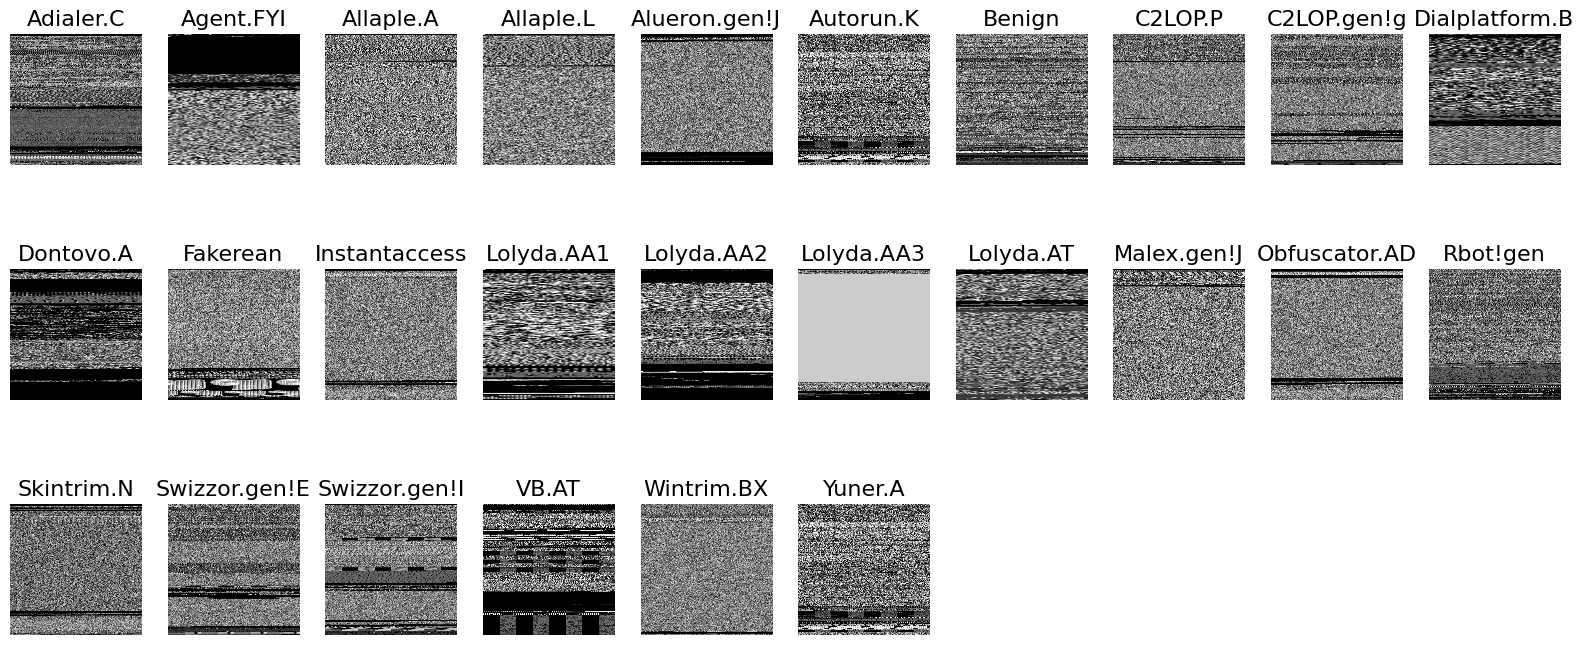

In [19]:
base_path_malign = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware"

samples = []
keys = []

for classe in classes:
  samples.append(os.path.join(base_path_malign,classe,os.listdir(os.path.join(base_path_malign,classe))[0]))
  keys.append(classe)

plots(samples, titles = keys)

# **Analysis of class distribution**

In [20]:
total_samples = pd.concat([train_df, test_df, val_df], ignore_index=True)

In [21]:

total_samples

,Unnamed: 0,img_code,target
0,0,./Adialer.C/0507a1034a8e029220bcd616fe903074.png,Adialer.C
1,1,./Adialer.C/04a98981751c2b0057cf38a4ee3e8f60.png,Adialer.C
2,2,./Adialer.C/0508626e758f9864b6001731bace699f.png,Adialer.C
3,3,./Adialer.C/04e15fe77e0cb0895de8532219d24b86.png,Adialer.C
4,4,./Adialer.C/05042268ee4fa6959f49e1d99d30fd71.png,Adialer.C
...,...,...,...
10416,2069,./Benign/c188aba86d2b56c50076304bf924e7bb1ab53...,Benign
10417,2070,./Benign/89441cca04cfaebcacaa194a59d78e1fee62f...,Benign
10418,2071,./Benign/d3dcb6b7c05940a0507e5ec8138a44a03c76b...,Benign
10419,2072,./Benign/ae8b7135284c9f111b34bf7ef631350b98f35...,Benign


In [22]:
occurences = total_samples.groupby(by = "target").size()

<BarContainer object of 26 artists>

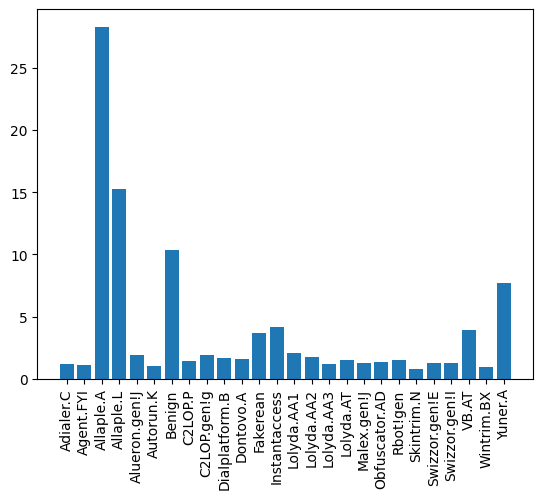

In [23]:
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), occurences/sum(occurences)*100)

# **Analysis of class distribution for each subset**

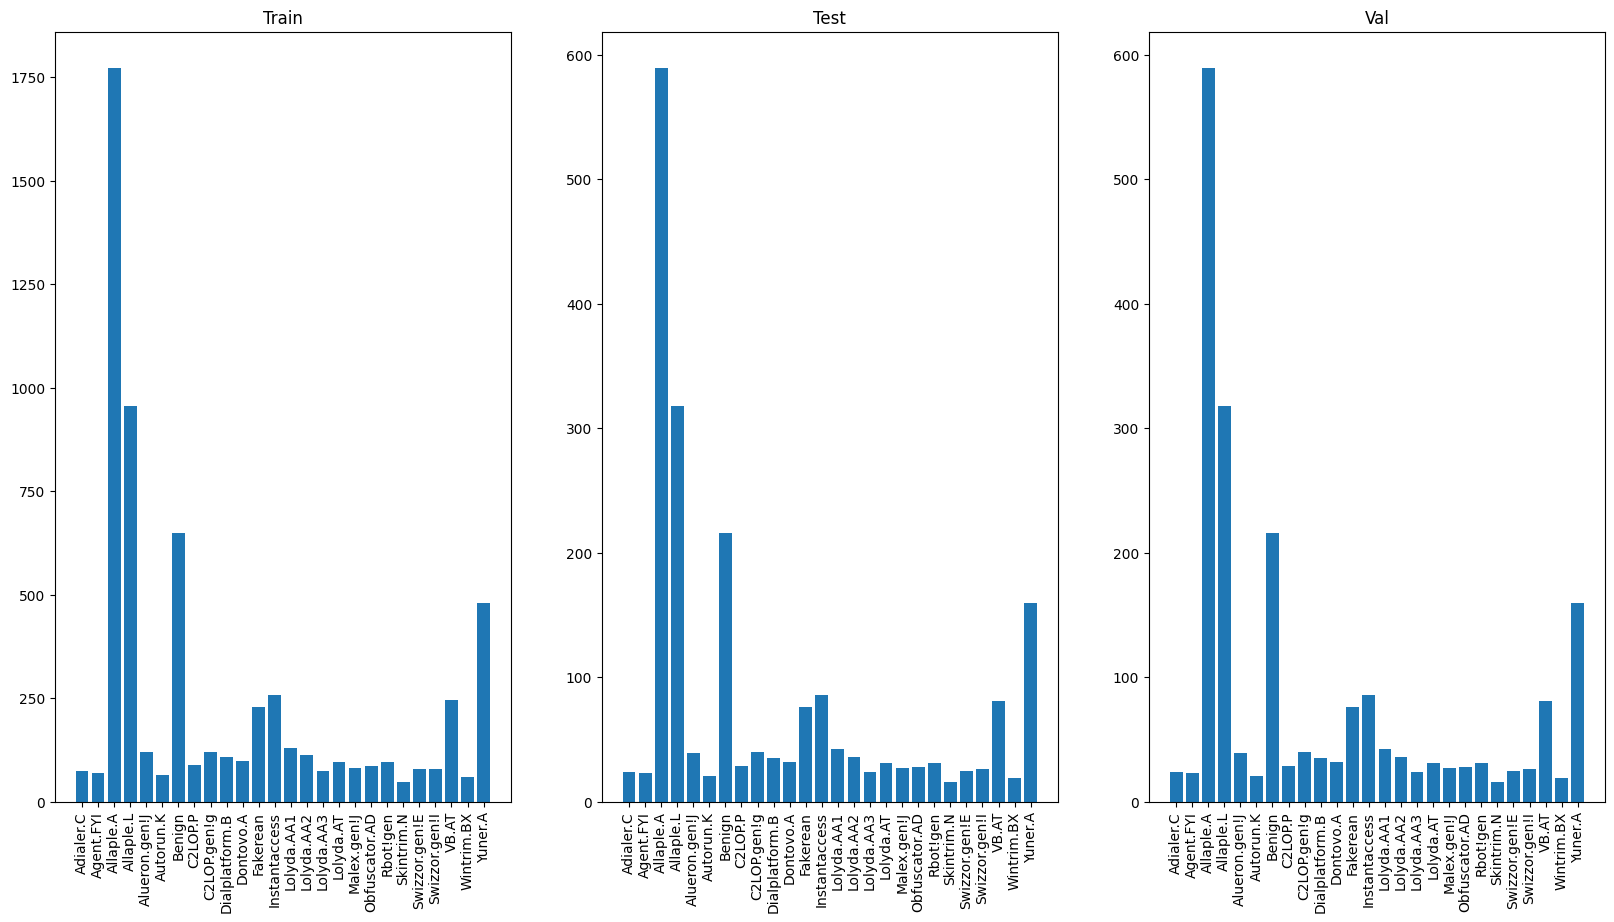

In [24]:
train_occ = train_df.groupby(by = "target").size()
test_occ = test_df.groupby(by = "target").size()
val_occ = val_df.groupby(by = "target").size()

occur = [train_occ, test_occ, val_occ]
name = ["Train", "Test", "Val"]

plt.figure(figsize = (20,10))

for i in range(3):

  plt.subplot(1,3,i+1)
  plt.title(name[i])
  plt.xticks(rotation = "vertical")
  plt.bar(classes.keys(), occur[i])

plt.show()

# **Class weight calculation**

In [25]:
train_labels = train_df.replace({"target":class_index})['target'].to_numpy()
class_indices =np.array(list(class_index.values()))
class_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [26]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = class_indices,
                                                  y = train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 3.2603950103950106,
 1: 3.446703296703297,
 2: 0.1362333318855058,
 3: 0.2526379379782521,
 4: 2.0105769230769233,
 5: 3.769831730769231,
 6: 0.37118343195266273,
 7: 2.741695804195804,
 8: 2.0105769230769233,
 9: 2.2548526240115025,
 10: 2.4619309262166404,
 11: 1.0535774269398723,
 12: 0.9315414315414315,
 13: 1.870304114490161,
 14: 2.1541895604395602,
 15: 3.2169230769230768,
 16: 2.4873116574147502,
 17: 2.9423076923076925,
 18: 2.8054561717352415,
 19: 2.5132211538461537,
 20: 5.0264423076923075,
 21: 3.0931952662721893,
 22: 3.0158653846153847,
 23: 0.9807692307692307,
 24: 4.089308996088657,
 25: 0.5026442307692308}

<BarContainer object of 26 artists>

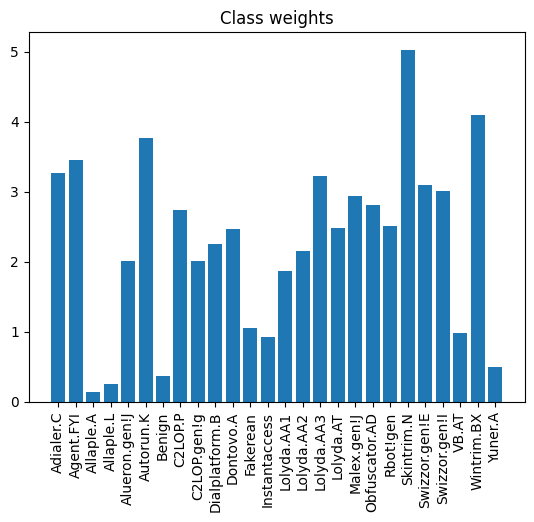

In [27]:
plt.title("Class weights")
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), class_weights.values())

# **Building the CNN**

In [28]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [29]:
num_classes = len(classes)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model

In [30]:
Malware_model = malware_model()
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0

In [31]:
cp_callback = ModelCheckpoint(save_checkpoints_path, verbose =1, monitor = "val_accuracy")

In [32]:
#Malware_model.load_weights(filepath = save_checkpoints_path, skip_mismatch=False, by_name=False, options=None)

# **Training**

In [33]:
history = Malware_model.fit(train_gen,validation_data=val_gen, epochs=10,  class_weight=class_weights, callbacks = [cp_callback])

Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 3.1134 - accuracy: 0.0603 - weighted_accuracy: 0.0812
Epoch 1: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt
197/197 [==============================] - 2572s 13s/step - loss: 3.1134 - accuracy: 0.0603 - weighted_accuracy: 0.0812 - val_loss: 2.5841 - val_accuracy: 0.2146 - val_weighted_accuracy: 0.2146
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 1.6457 - accuracy: 0.3949 - weighted_accuracy: 0.5147
Epoch 2: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt
197/197 [==============================] - 1068s 5s/step - loss: 1.6457 - accuracy: 0.3949 - weighted_accuracy: 0.5147 - val_loss: 1.0558 - val_accuracy: 0.8380 - val_weighted_accuracy: 0.8380
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.8316 - accuracy: 0.7486 - weighte

# **History saving**

In [34]:
hist_df = pd.DataFrame(history.history)
with open(history_saving_path_json, 'wb') as file_pi:
    hist_df.to_json(file_pi)

# **Model training plots**

dict_keys(['loss', 'accuracy', 'weighted_accuracy', 'val_loss', 'val_accuracy', 'val_weighted_accuracy'])


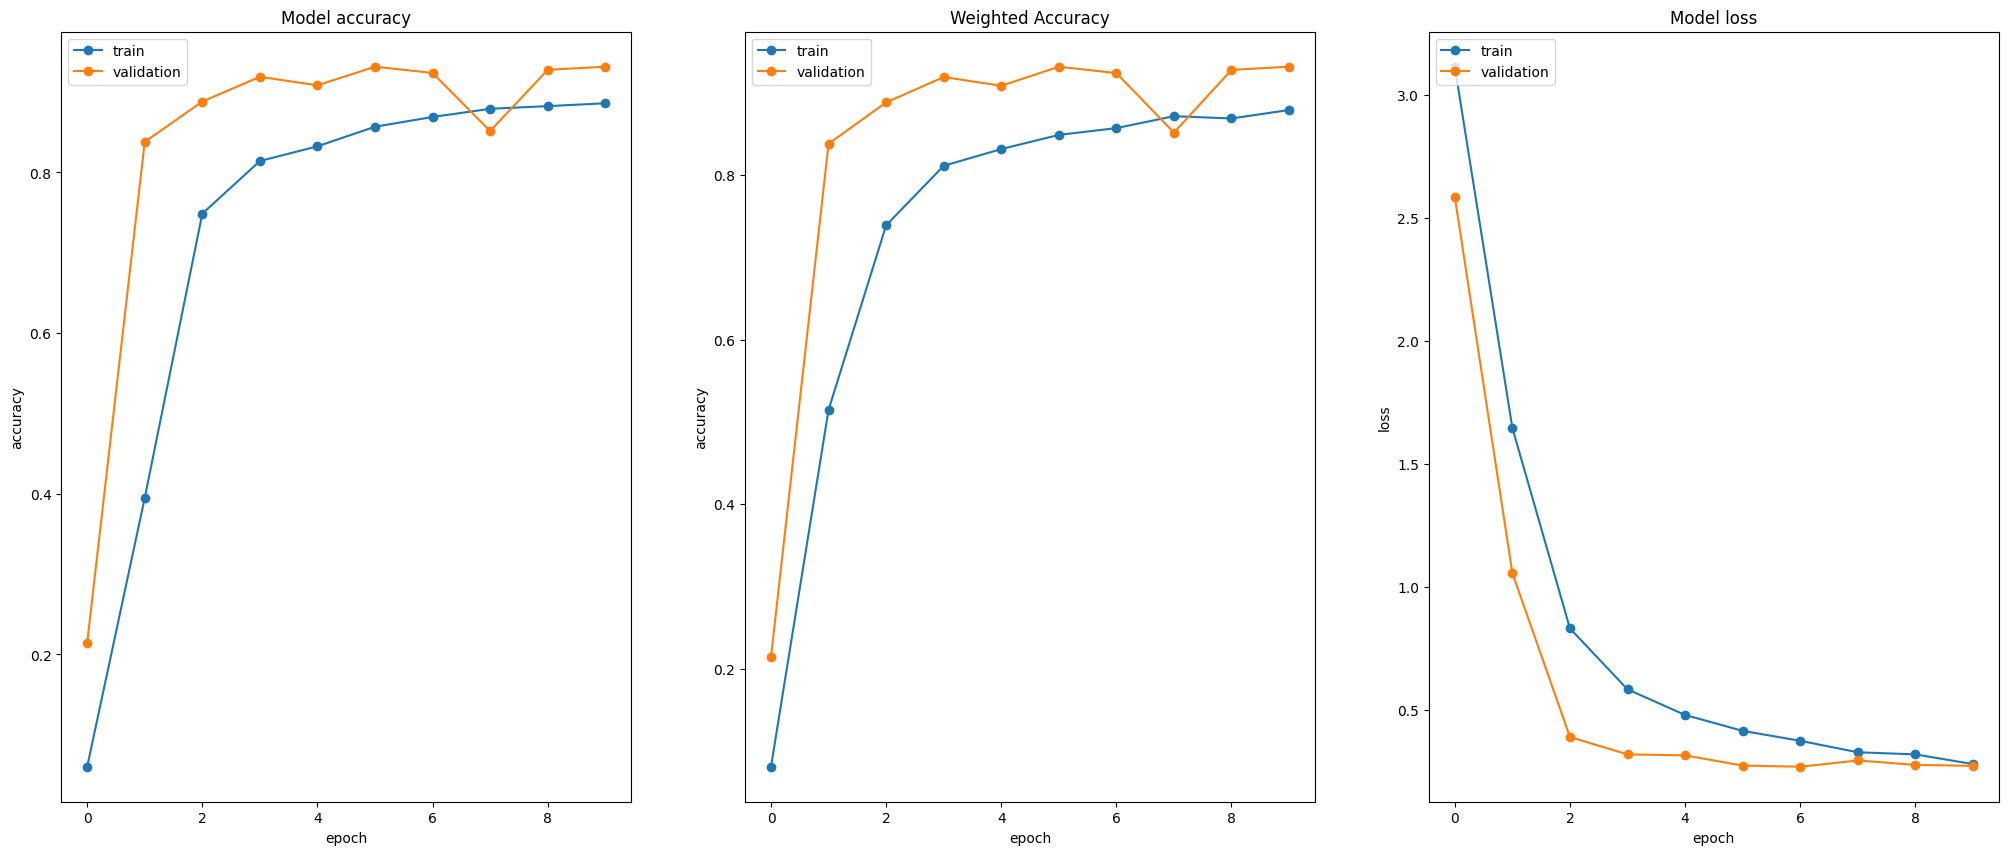

In [35]:
print(history.history.keys())
plt.figure(figsize = (25,10))
#  "Accuracy"
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#  "Weighted Accuracy"
plt.subplot(1,3,2)
plt.plot(history.history['weighted_accuracy'], marker='o')
plt.plot(history.history['val_weighted_accuracy'], marker='o')
plt.title('Weighted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# "Loss"
plt.subplot(1,3,3)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Results on Validation Set**

In [36]:
metric_list = Malware_model.evaluate(val_gen, batch_size=32, verbose=1)

print('evaluate_accuracy=%.3f' %metric_list[1])
print('evaluate_weighted_accuracy=%.3f' %metric_list[2])

65/65 [==============================] - 85s 1s/step - loss: 0.2732 - accuracy: 0.9315 - weighted_accuracy: 0.9315
evaluate_accuracy=0.932
evaluate_weighted_accuracy=0.932


# **Confusion matrix**

In [37]:
val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)



y_pred = Malware_model.predict(val_gen)
y_test_predicted = np.argmax(np.array(y_pred),axis = 1)

Found 2074 validated image filenames belonging to 26 classes.
65/65 [==============================] - 86s 1s/step


In [38]:

from sklearn import metrics

In [39]:
c_matrix = metrics.confusion_matrix(val_gen.classes, y_test_predicted)
df_confusion = pd.crosstab(val_gen.classes, y_test_predicted)
df_confusion.to_csv(os.path.join(root_path,"confusion_matrix.csv"))

In [40]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

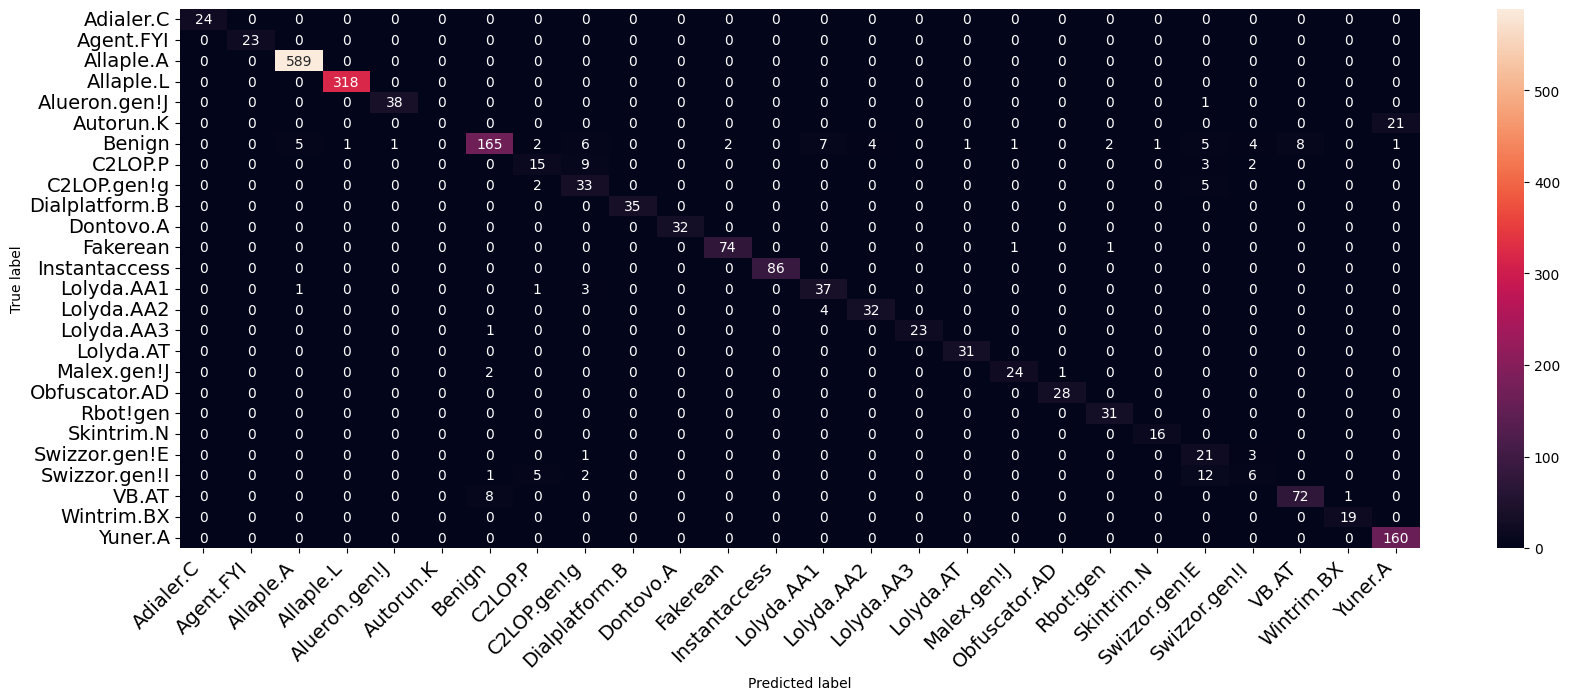

In [41]:
confusion_matrix(c_matrix, classes, figsize = (20,7), fontsize=14)

In [42]:
report = metrics.classification_report(val_gen.classes, y_test_predicted, target_names=classes,  output_dict=True)
print(report)

{'Adialer.C': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 24}, 'Agent.FYI': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23}, 'Allaple.A': {'precision': 0.9899159663865547, 'recall': 1.0, 'f1-score': 0.9949324324324325, 'support': 589}, 'Allaple.L': {'precision': 0.9968652037617555, 'recall': 1.0, 'f1-score': 0.9984301412872841, 'support': 318}, 'Alueron.gen!J': {'precision': 0.9743589743589743, 'recall': 0.9743589743589743, 'f1-score': 0.9743589743589743, 'support': 39}, 'Autorun.K': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21}, 'Benign': {'precision': 0.9322033898305084, 'recall': 0.7638888888888888, 'f1-score': 0.8396946564885496, 'support': 216}, 'C2LOP.P': {'precision': 0.6, 'recall': 0.5172413793103449, 'f1-score': 0.5555555555555556, 'support': 29}, 'C2LOP.gen!g': {'precision': 0.6111111111111112, 'recall': 0.825, 'f1-score': 0.7021276595744681, 'support': 40}, 'Dialplatform.B': {'precision': 1.0, 'recall': 1.0, 'f1-score':

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:

df_report = pd.DataFrame(report).transpose()
df_report.to_csv(os.path.join(root_path,"report.csv"))
